In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [2]:
n_rep = 100
n_bins = 1000
n_nodes = 10
n_regions = 40
n_reads = 10000
PATH = '../../workflows/bp_detection_performance/results/'

In [3]:
gt_files = [PATH + str(n_nodes)+'nodes_'+str(n_regions)+'regions_'+str(n_reads) \
             +'reads_simdata_'+str(x)+'_ground_truth.txt' for x in range(0,n_rep)]
bps_files = [PATH + 'simdata_'+str(x)+'_all_bps_comparison.csv' for x in range(0,n_rep)]
all_bins = range(0,n_bins)

In [4]:
all_bins

range(0, 1000)

In [5]:
all_tpr = []
all_fpr = []
all_n_positives = []
all_bps_tables = []

threshold_coeffs = np.linspace(1.0,16.0, 100) # 100 thresholds btw 1 and 16

for gt_file, bps_file in tqdm(zip(gt_files, bps_files)):
    bps = pd.read_csv(bps_file, header=None)
    bps.columns = ['idx','log_sp','stdev']
    bps['ranking'] = bps['log_sp'] / bps['stdev']
    # bps = bps.sort_values('ranking',ascending=False)
    bps = bps.dropna()
    
    all_bps_tables.append(bps)
    
    # get the ground truth
    cell_genotypes = pd.read_csv(gt_file, sep=' ' ,header=None)
    cell_genotypes = cell_genotypes[cell_genotypes.columns[:-1]] # remove the last (only NaN) column
    cell_bps = cell_genotypes.diff(periods=1, axis=1) # apply diff to detect breakpoints
    cell_bps = cell_bps.fillna(value=0.0) # diff makes the 1st row NaN, make it zero
    cell_bps[cell_bps != 0] = 1 # replace the non-zeroes by 1
    grouped_cell_bps = cell_bps.sum(axis=0) # count the non-zeroes
    ground_truth = grouped_cell_bps[grouped_cell_bps > 0] # if they occur in at least 1 cell
    ground_truth = ground_truth.index.tolist()
    # end of ground truth    

    # correcting for the bps 1-2 bins nearby
    for index, row in bps.iterrows():
        idx_val = bps.loc[index, 'idx']
        for gt in ground_truth:
            if (abs(idx_val - gt) <=2 and idx_val != gt):
                print('correcting ' + str(idx_val) + '->' + str(gt))
                bps.loc[index,'idx'] = gt
    
    # use a fixed threshold_coeffs for all
    # threshold_coeffs = sorted(bps['ranking'].values)
    print('len threshold coeffs' + str(len(threshold_coeffs)))
    # Each breakpoint candidate has a different stdev value.
    # The ROC computations takes that into account.tpr_values = []
    tpr_values = []
    fpr_values = []
    n_positives = []
    for thr in threshold_coeffs:
        predicted_positives = []
        predicted_negatives = []
        for index, row in bps.iterrows():
            if row['ranking'] > thr:
                predicted_positives.append(row['idx'])
            else:
                break 
                
        #import ipdb; ipdb.set_trace()
        predicted_negatives = [i for i in all_bins if i not in predicted_positives]

        true_positives = [i for i in predicted_positives if i in ground_truth]
        false_positives = [i for i in predicted_positives if i not in ground_truth]

        true_negatives = [i for i in predicted_negatives if i not in ground_truth]
        false_negatives = [i for i in predicted_negatives if i in ground_truth]

        # import ipdb; ipdb.set_trace()
        assert(len(ground_truth) == (len(true_positives) + len(false_negatives)))
        tpr = len(true_positives) / len(ground_truth) # len(ground_truth)
        fpr = len(false_positives) / (1000 - len(ground_truth)) # (len(false_positives) + len(true_negatives))
        tpr_values.append(tpr)
        fpr_values.append(fpr)
        n_positives.append(len(predicted_positives))
    
    all_tpr.append(tpr_values)
    all_fpr.append(fpr_values)
    all_n_positives.append(n_positives)

A Jupyter Widget

correcting 652->651
correcting 206->207
correcting 526->525
correcting 762->761
correcting 881->880
len threshold coeffs100
correcting 366->365
len threshold coeffs100
correcting 644->645
correcting 888->889
correcting 598->597
len threshold coeffs100
correcting 674->673
correcting 803->804
len threshold coeffs100
correcting 628->629
correcting 446->447
correcting 206->207
len threshold coeffs100
correcting 441->440
correcting 912->913
correcting 871->869
correcting 198->199
len threshold coeffs100
correcting 926->927
len threshold coeffs100
correcting 390->391
len threshold coeffs100
correcting 187->189
correcting 138->137
correcting 648->647
len threshold coeffs100
correcting 485->484
correcting 504->505
correcting 521->520
len threshold coeffs100
correcting 577->579
len threshold coeffs100
correcting 617->616
correcting 328->330
correcting 264->263
len threshold coeffs100
correcting 902->903
correcting 878->876
correcting 558->559
correcting 14->13
correcting 374->373
len threshold 

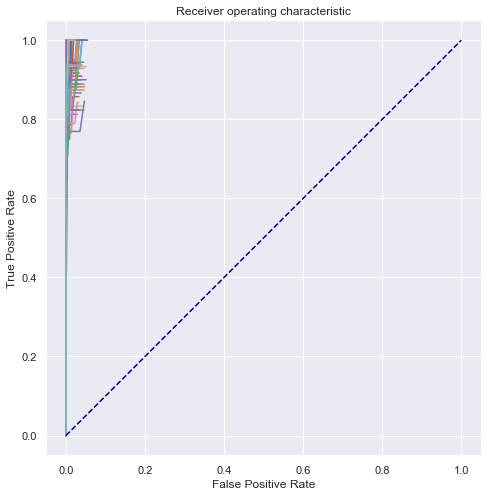

In [6]:
auc_vals = []
plt.figure(figsize=(8,8))
for tpr_values, fpr_values in zip(all_tpr, all_fpr):
    roc_auc = auc(fpr_values, tpr_values)
    auc_vals.append(roc_auc)
    plt.plot(fpr_values, tpr_values) # label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
plt.show()

In [7]:
threshold_indices = []
for idx, val in enumerate(all_tpr):
    df = pd.DataFrame(data=[all_tpr[idx],all_fpr[idx]]).T
    df.columns = ['tpr','fpr']
    df['idx'] = df.index
    df = df[df['tpr']==df['tpr'].max()]
    df = df[df['fpr']==df['fpr'].min()]
    print(df)
    thr_idx = df.idx.values[0]
    threshold_indices.append(thr_idx)

   tpr       fpr  idx
4  1.0  0.004077    4
    tpr  fpr  idx
3   1.0  0.0    3
4   1.0  0.0    4
5   1.0  0.0    5
6   1.0  0.0    6
7   1.0  0.0    7
8   1.0  0.0    8
9   1.0  0.0    9
10  1.0  0.0   10
11  1.0  0.0   11
12  1.0  0.0   12
13  1.0  0.0   13
14  1.0  0.0   14
15  1.0  0.0   15
16  1.0  0.0   16
17  1.0  0.0   17
18  1.0  0.0   18
19  1.0  0.0   19
20  1.0  0.0   20
21  1.0  0.0   21
22  1.0  0.0   22
23  1.0  0.0   23
24  1.0  0.0   24
25  1.0  0.0   25
26  1.0  0.0   26
27  1.0  0.0   27
28  1.0  0.0   28
29  1.0  0.0   29
      tpr       fpr  idx
2  0.9375  0.031504    2
        tpr       fpr  idx
5  0.909091  0.012133    5
   tpr       fpr  idx
8  1.0  0.001018    8
        tpr       fpr  idx
4  0.928571  0.008114    4
    tpr      fpr  idx
12  1.0  0.00304   12
13  1.0  0.00304   13
14  1.0  0.00304   14
15  1.0  0.00304   15
   tpr       fpr  idx
3  1.0  0.004057    3
        tpr       fpr  idx
9  0.833333  0.004073    9
   tpr       fpr  idx
8  1.0  0.003049    

In [8]:
len(threshold_indices)

100

In [9]:
len(all_tpr[0])

100

In [10]:
all_bps_tables[0].shape

(39, 4)

In [11]:
all_bps_tables[0]

,idx,log_sp,stdev,ranking
0,486,7.832510,0.573711,13.652362
1,474,3.403270,0.364035,9.348744
2,88,2.135580,0.321187,6.649024
3,651,2.108340,0.309920,6.802852
4,636,1.945790,0.293162,6.637252
5,536,1.931560,0.282128,6.846396
6,207,1.864430,0.259745,7.177925
7,773,1.819980,0.245838,7.403168
8,162,1.780400,0.216057,8.240418
9,791,1.744600,0.193241,9.028105


In [12]:
bps_thresholds = []
for idx, val in enumerate(threshold_indices):
    bps_thresholds.append(all_bps_tables[idx].iloc[[val]]['ranking'].values[0])

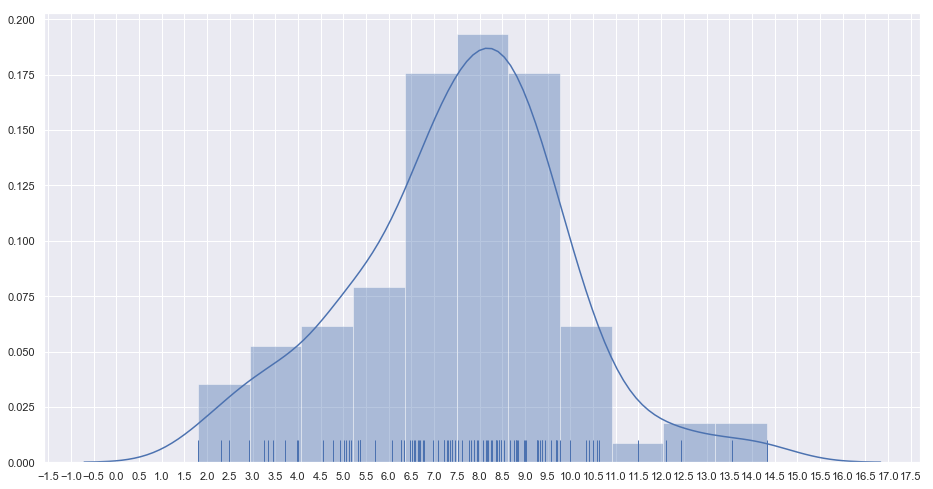

In [13]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.distplot(bps_thresholds, rug=True);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

## Average TRP, FPR, number of predicted positives for each threshold value over 100 runs
For each run.

In [14]:
tpr_df = pd.DataFrame(all_tpr)
tpr_df.columns = threshold_coeffs
tpr_df.head()

,1.0,1.1515151515151516,1.303030303030303,1.4545454545454546,1.606060606060606,1.7575757575757576,1.9090909090909092,2.0606060606060606,2.212121212121212,2.3636363636363638,...,14.636363636363637,14.787878787878789,14.93939393939394,15.090909090909092,15.242424242424242,15.393939393939394,15.545454545454547,15.696969696969697,15.84848484848485,16.0
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.947368,0.947368,0.947368,0.947368,0.947368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.937500,0.937500,0.937500,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,0.875000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.818182,0.818182,0.818182,0.818182,...,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.0,0.0,0.0
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.944444,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


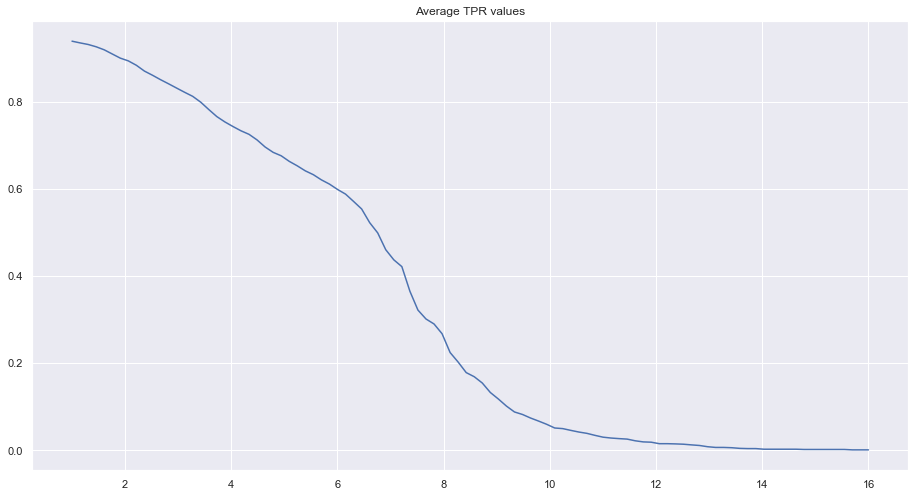

In [15]:
mean_tpr = tpr_df.mean()
plt = sns.lineplot(x=mean_tpr.index,y=mean_tpr.values).set_title('Average TPR values')

In [16]:
fpr_df = pd.DataFrame(all_fpr)
fpr_df.columns = threshold_coeffs
fpr_df.head()

,1.0,1.1515151515151516,1.303030303030303,1.4545454545454546,1.606060606060606,1.7575757575757576,1.9090909090909092,2.0606060606060606,2.212121212121212,2.3636363636363638,...,14.636363636363637,14.787878787878789,14.93939393939394,15.090909090909092,15.242424242424242,15.393939393939394,15.545454545454547,15.696969696969697,15.84848484848485,16.0
0,0.019368,0.013252,0.007136,0.007136,0.004077,0.003058,0.003058,0.002039,0.001019,0.001019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.006091,0.005076,0.002030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.038618,0.033537,0.031504,0.025407,0.021341,0.016260,0.012195,0.006098,0.003049,0.001016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.040445,0.030334,0.029323,0.024267,0.019211,0.012133,0.008089,0.007078,0.006067,0.005056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.029532,0.020367,0.014257,0.010183,0.008147,0.006110,0.004073,0.002037,0.001018,0.001018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


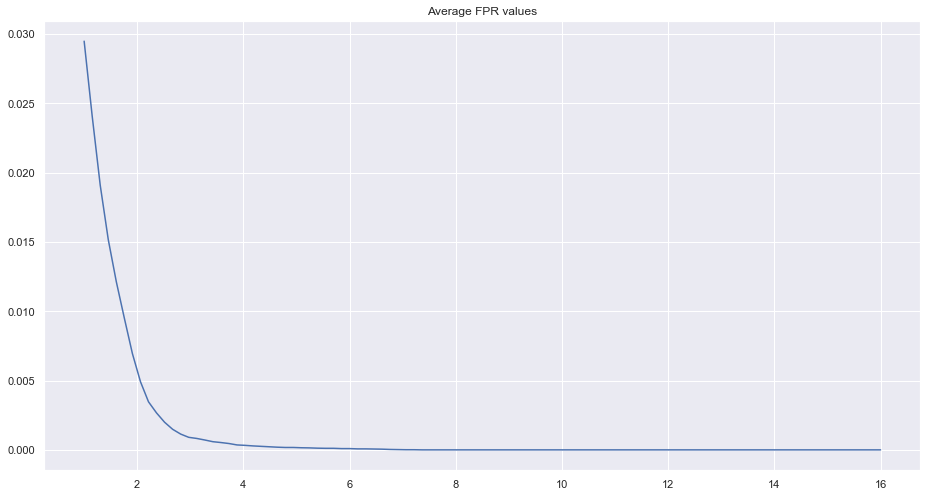

In [17]:
mean_fpr = fpr_df.mean()
plt = sns.lineplot(x=mean_fpr.index,y=mean_fpr.values).set_title('Average FPR values')

In [18]:
n_positives_df = pd.DataFrame(all_n_positives)
n_positives_df.columns = threshold_coeffs
n_positives_df.head()

,1.0,1.1515151515151516,1.303030303030303,1.4545454545454546,1.606060606060606,1.7575757575757576,1.9090909090909092,2.0606060606060606,2.212121212121212,2.3636363636363638,...,14.636363636363637,14.787878787878789,14.93939393939394,15.090909090909092,15.242424242424242,15.393939393939394,15.545454545454547,15.696969696969697,15.84848484848485,16.0
0,38,32,26,26,23,21,21,20,19,19,...,0,0,0,0,0,0,0,0,0,0
1,21,20,17,15,15,15,15,15,15,15,...,0,0,0,0,0,0,0,0,0,0
2,53,48,46,39,35,30,26,20,17,15,...,0,0,0,0,0,0,0,0,0,0
3,50,40,39,34,29,22,17,16,15,14,...,1,1,1,1,1,1,1,0,0,0
4,47,38,32,28,26,24,22,20,19,18,...,0,0,0,0,0,0,0,0,0,0


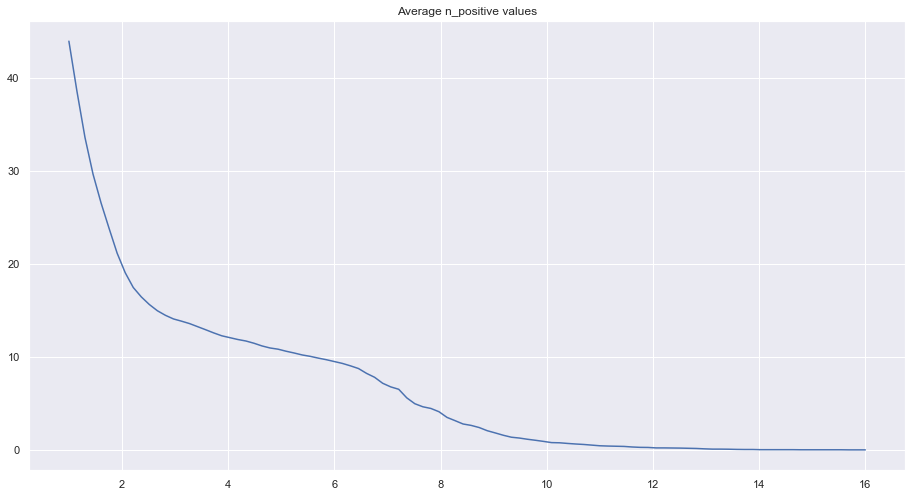

In [19]:
mean_n_positives = n_positives_df.mean()
plt = sns.lineplot(x=mean_n_positives.index,y=mean_n_positives.values).set_title('Average n_positive values')

In [20]:
df_avg = pd.DataFrame(data={'mean_tpr': mean_tpr, 'mean_fpr': mean_fpr})

In [21]:
df_avg.head()

,mean_tpr,mean_fpr
1.000000,0.938913,0.029481
1.151515,0.934966,0.024075
1.303030,0.931368,0.019085
1.454545,0.926055,0.015163
1.606061,0.919092,0.012124


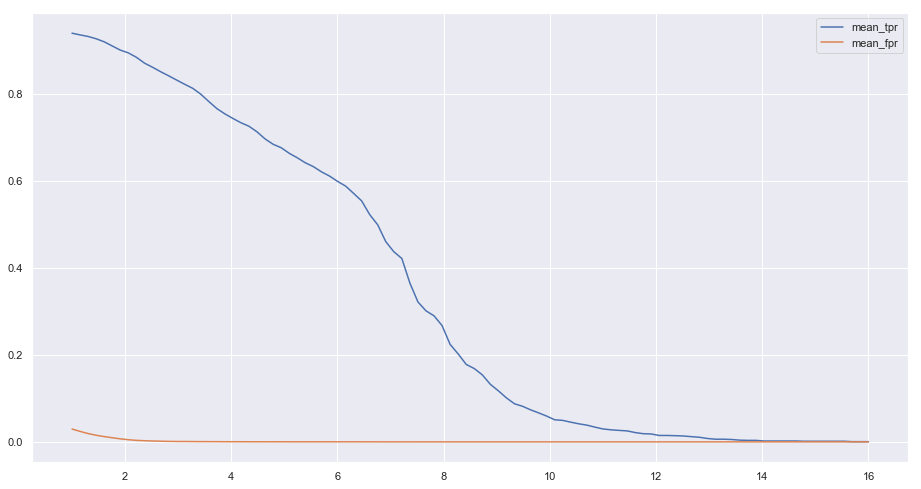

In [22]:
df_avg.plot()